In [1]:
from bs4 import BeautifulSoup
import requests

import csv

import pandas as pd
import numpy as np

import datetime
import pytz

import matplotlib.pyplot as plt
%matplotlib notebook
pd.plotting.register_matplotlib_converters()

In [2]:
stationId = 56003
dataType = 0
startYear = 2019
startMonth = 12
startDay = 1
endYear = 2020
endMonth = 1
endDay = 1

url = 'https://www.ndbc.noaa.gov/station_page.php?' + \
        'station=' + str(stationId) + '&' + \
        'type=' + str(dataType) + '&' + \
        'startyear=' + str(startYear) + '&' + \
        'startmonth=' + str(startMonth).zfill(2) + '&' + \
        'startday=' + str(startDay).zfill(2) + '&' + \
        'endyear=' + str(endYear) + '&' + \
        'endmonth=' + str(endMonth).zfill(2) + '&' + \
        'endday=' + str(endDay).zfill(2) + '&' + \
        'submit=Submit'

req = requests.get(url)

html_doc = req.text

In [3]:
soup = BeautifulSoup(html_doc, 'html.parser')

In [4]:
for element in soup.find_all('textarea'):
    data = element.text

In [5]:
splitData = data.split('\n')

with open('test.csv', 'w') as file:
    for line in splitData[:-1]:
        try:
            # Check if it is header
            if line[0] == '#':
                continue
            # Add to CSV
            else:
                file.write(line)
                file.write('\n')
        except IndexError:
            print(line + 'hi')

In [6]:
dataFrame = pd.read_csv('test.csv', header=None, delimiter = r'\s+')

In [7]:
year = dataFrame[0]
month = dataFrame[1]
day = dataFrame[2]
hour = dataFrame[3]
minute = dataFrame[4]
second = dataFrame[5]
dataType = dataFrame[6]
height = dataFrame[7]

In [8]:
date_time = []
for x in range(len(year)):
    date_time.append(datetime.datetime(year = year[x],
                                       month = month[x],
                                       day = day[x],
                                       hour = hour[x],
                                       minute = minute[x],
                                       second = second[x],
                                       tzinfo = pytz.utc))

In [9]:
len(date_time)

3130

In [10]:
len(height)

3130

In [11]:
zippedList = list(zip(date_time, height))
dataFrame = pd.DataFrame(zippedList, columns = ['datetime', 'height'])

In [12]:
dataFrame

,datetime,height
0,2020-01-01 00:00:00+00:00,5657.403
1,2019-12-31 23:45:00+00:00,5657.390
2,2019-12-31 23:30:00+00:00,5657.393
3,2019-12-31 23:15:00+00:00,5657.413
4,2019-12-31 23:00:00+00:00,5657.447
...,...,...
3125,2019-12-01 01:00:00+00:00,5657.734
3126,2019-12-01 00:45:00+00:00,5657.609
3127,2019-12-01 00:30:00+00:00,5657.494
3128,2019-12-01 00:15:00+00:00,5657.390


In [13]:
np.average(dataFrame['height'])

5658.511334824281

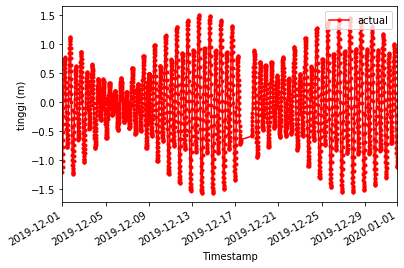

In [14]:
def plotFigure(x_act, y_act):    
    figure = plt.figure()
    axes1 = figure.add_subplot(111)
    axes1.set_ylabel('tinggi (m)')
    axes1.set_xlabel('Timestamp')
    axes1.plot(x_act, y_act, marker = '.', color = 'red', 
                  label = 'actual')
    axes1.legend(loc = 'upper right')
    axes1.set_xlim(x_act[-1], x_act[0])
    plt.gcf().autofmt_xdate()
    plt.show()

listDatetime = dataFrame['datetime'].to_list()
listHeight = dataFrame['height'].to_list()

averageData = np.average(listHeight)
listHeight = np.subtract(listHeight, averageData)

plotFigure(listDatetime, listHeight)

In [15]:
dataFrame['datetime']

0      2020-01-01 00:00:00+00:00
1      2019-12-31 23:45:00+00:00
2      2019-12-31 23:30:00+00:00
3      2019-12-31 23:15:00+00:00
4      2019-12-31 23:00:00+00:00
                  ...           
3125   2019-12-01 01:00:00+00:00
3126   2019-12-01 00:45:00+00:00
3127   2019-12-01 00:30:00+00:00
3128   2019-12-01 00:15:00+00:00
3129   2019-12-01 00:00:00+00:00
Name: datetime, Length: 3130, dtype: datetime64[ns, UTC]

In [16]:
averageData

5658.511334824281